In [17]:
from dependencies import *

In [18]:
# solar luminosity
t_Earth = 0.72 # Gya
L_L0 = 1/(1+2/5*(1-(4.5-t_Earth)/4.5)) # Gough et al. 1981 equation for solar luminosity evolution
S_Neo = L_L0*1361 # Neoproterozoic solar constant [W/m2]
F_Neo = S_Neo/4*(1-0.3) # Neoproterozoic ASR [W/m2]

# assume equilibrium pCO2 balances solar forcing
F_diff = (1361-S_Neo)/4*(1-0.3) # difference in ASR
pCO2_Neo = np.exp(F_diff/5.35)*280 # Neoproterozoic CO2 required to balance

print(f"{t_Earth} billion years ago")
print(f"the Sun was {L_L0:0.0%} as bright as now")
print(f"i.e. the solar constant was {S_Neo:0.0f} W/m2")
print(f"and absorbed solar radiation (ASR) was {F_Neo:0.0f} W/m2")
print(f"we therefore assume pCO2 was {pCO2_Neo:0.0f} ppm")

0.72 billion years ago
the Sun was 94% as bright as now
i.e. the solar constant was 1279 W/m2
and absorbed solar radiation (ASR) was 224 W/m2
we therefore assume pCO2 was 4075 ppm


In [19]:
defaults = {
    "Ti": 260,    # ice-covered temp [K]
    "To": 295,    # ice-free temp [K]
    "ai": 0.6,    # ice-covered albedo
    "ao": 0.2,   # ice-free albedo
    "F": 1285,    # solar constant
    "T0": 288,    # initial temperature [K]
    "pCO20": 280, # initial pCO2 [ppm]
    "b": 5.35,    # CO2 radiative forcing coefficient [W/m2]
    "a_coeff": 2, # temperature response to radiative forcing [W/m2/K]
    "S": S_Neo,     # Neoproterozoic solar constant [W/m2]
    "pCO20": pCO2_Neo  # assume CO2 balanced weaker solar forcing
}

In [20]:
# calculate radiative forcing

def albedo_scalar(T, config=defaults):
    Ti, To, ai, ao = config["Ti"], config["To"], config["ai"], config["ao"]
    
    if T <= Ti:
        return ai
    elif T < To:
        return ao + (ai - ao) * (T - To)**2 / (Ti - To)**2
    else:
        return ao

albedo = np.vectorize(albedo_scalar)

In [21]:
# compute radiative forcing

# solar forcing
def delS(a, config=defaults):
    S,T0,Ti,To,ai,ao = config["S"],config["T0"],config["Ti"],config["To"],config["ai"],config["ao"]
    
    a0 = albedo(T0, config=config)
    F0 = S * (1 - a0) / 4
    F = S * (1 - a) / 4
    return F - F0

# CO2 forcing
def delCO2(pCO2, config=None):
    pCO20, b = config["pCO20"], config["b"]
    
    y = pCO2/pCO20
    return b * np.log(y)

# change in temperature
def delT(a,pCO2,config=defaults):
    a_coeff = config["a_coeff"]
    radS = delS(a=a, config=config) # solar forcing
    radCO2 = delCO2(pCO2, config=config) # CO2 forcing
    return (radS + radCO2) / a_coeff

In [22]:
# find equilibrium temperature
def find_Teq(pCO2,
             a0=0.3, # set to < ai to start in a snowball, >ao to start in ice-free state
             threshold=0.1, # threshold for considering T stable [K]
             max_iters=1000,
             plot_evol=False, # keep track of T and albedo evolution
             config=defaults):
    T = T0 = config["T0"]
    a = a0
    
    if plot_evol:
        T_arr = []
        a_arr = []
            
    for i in range(max_iters):
        # update radiative forcing and calculate T
        x = delT(a=a, pCO2=pCO2, config=config)
        new_T = T0 + x

        # check if T has reached equilbrium
        if abs(new_T - T) < threshold:
            #print(new_T,T)
            T = new_T
            break

        # update T and albedo
        T = new_T
        a = albedo(T, config=config)
        
        if plot_evol:
            T_arr.append(T)
            a_arr.append(a)
                    
    if plot_evol:
        return np.array(T_arr),np.array(a_arr)
    else:
        return T
    

def find_gap(T_arr,pCO2_arr = None):
    sorted_arr = np.sort(T_arr)
    diff_arr = np.diff(sorted_arr)
    gap_idx = np.argmax(diff_arr)
    lower_max = sorted_arr[gap_idx]
    upper_min = sorted_arr[gap_idx + 1]
    if pCO2_arr is not None:
        lower_max_pCO2 = pCO2_arr[gap_idx]
        upper_min_pCO2 = pCO2_arr[gap_idx + 1]
        return lower_max,upper_min,lower_max_pCO2,upper_min_pCO2
    return lower_max,upper_min

In [23]:
pCO2_arr = np.logspace(start=0,stop=7,num=10000)
start_ice = []
start_icefree = []

for pCO2 in pCO2_arr:
    start_ice.append(find_Teq(pCO2=pCO2,a0=1,config=defaults))
    start_icefree.append(find_Teq(pCO2=pCO2,a0=0,config=defaults))
        
print('glaciation at %0.1f K, jumps to %0.1f K'%find_gap(start_icefree)[::-1])
print('deglaciation at %0.1f K, jumps to %0.1f K'%find_gap(start_ice))

glaciation at 285.5 K, jumps to 226.2 K
deglaciation at 204.4 K, jumps to 204.4 K


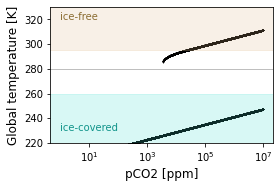

In [26]:
plt.rcParams.update({'legend.fontsize':9,
                     'font.size':10,
                     'lines.linewidth':1,
                     'axes.titlesize':10})
    
fig,ax = plt.subplots(figsize=(4,2.5))
ax.scatter(pCO2_arr,start_ice,s=0.1,c='k',#c='#10948a',
           label='starting from ice-covered')
ax.scatter(pCO2_arr,start_icefree,s=0.1,c='k',#c='#8b6d32',
           label='starting from ice-free')
ax.set_xscale('log')

#ax.scatter(Neoproterozoic["pCO20"],defaults["T0"],c='k')

ax.axhspan(220,260,alpha=0.2,color='turquoise',label='ice-covered')
ax.axhspan(295,330,alpha=0.2,color='burlywood',label='ice-free')
ax.set_ylim(220,330)
ax.set_xlabel("pCO2 [ppm]")
ax.set_ylabel("Global temperature [K]")
ax.text(1e0,230,"ice-covered",c='#10948a')
ax.text(1e0,320,"ice-free",c='#8b6d32')

ax.axhline(280,c='grey',alpha=0.5)
figname = "figs/bifurcation"
plt.savefig(figname+'.jpg',format='jpg',bbox_inches='tight',dpi=600)
plt.show()